# 1. Configuração do ambiente

In [ ]:
!pip install opencv-python numpy google-cloud-storage

In [ ]:
!pip install google-cloud-vision

In [ ]:
!pip install --upgrade tensorflow keras protobuf
!pip install --upgrade google-cloud-storage

In [4]:
import numpy as np
import cv2
from google.cloud import storage
from google.cloud import vision
import io
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import shutil
import pathlib
import seaborn as sns

In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Activation
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2

In [8]:
# Parâmetros de Imagem/Treinamento
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
TRAIN_SPLIT = 0.8  # 80% treino, 20% validação
EPOCAS_TESTE = 20  # Use 20 para teste. MUDAR PARA 250 NO TREINAMENTO FINAL!

# Parâmetros da MobileNetV2
NUM_CLASSES = 6

# Parâmetros de Segmentação
MIN_DIST = 300
PARAM2 = 25
MIN_RADIUS = 270
MAX_RADIUS = 350

NOME_DO_BUCKET = "moedasbrasileiras"


In [9]:
# Inicializa o cliente do GCS
storage_client = storage.Client()
bucket = storage_client.bucket(NOME_DO_BUCKET)
vision_client = vision.ImageAnnotatorClient()

# Testes de processamento

Buscando a primeira imagem em: moedasbrasileiras...
Processando e exibindo: Moedas brasileiras/1-centavo-1999-rara-cdfc1bf2d7fcec1d0617174402017751-1024-1024.png


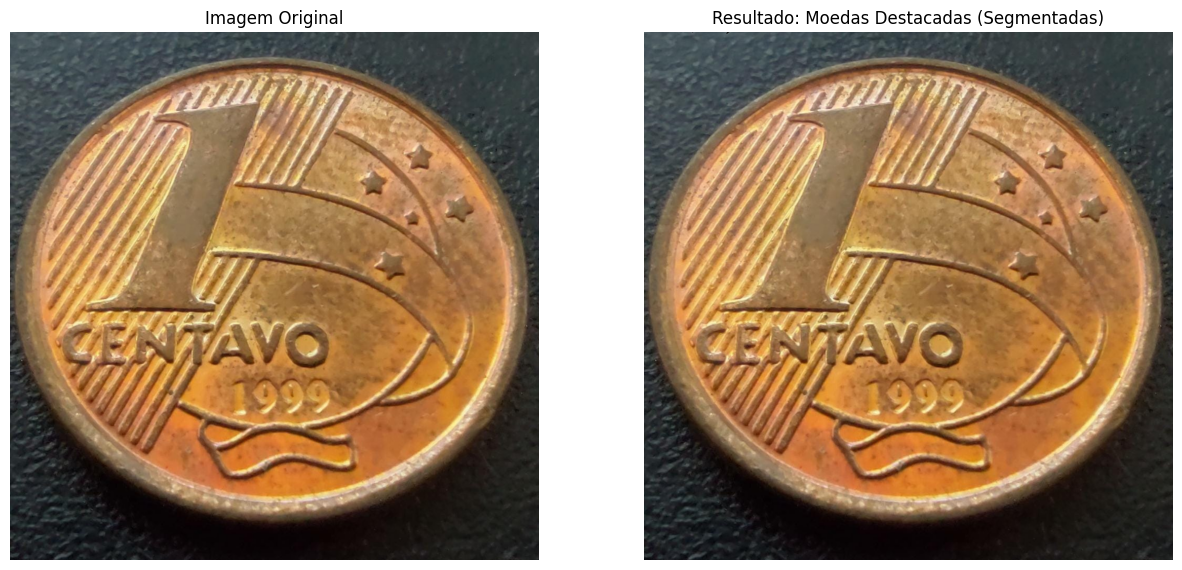

In [ ]:
print(f"Buscando a primeira imagem em: {NOME_DO_BUCKET}...")

# 1. Carregar a Primeira Imagem Válida
primeiro_blob = None
for blob in bucket.list_blobs():
    if blob.name.lower().endswith(('.jpg', '.jpeg', '.png')):
        primeiro_blob = blob
        break

if primeiro_blob is None:
    print("ERRO: Nenhuma imagem válida encontrada no bucket.")
else:
    print(f"Processando e exibindo: {primeiro_blob.name}")

    # Faz o download do conteúdo da imagem em memória (bytes)
    imagem_bytes = primeiro_blob.download_as_bytes()
    imagem_array = np.frombuffer(imagem_bytes, np.uint8)
    imagem_original = cv2.imdecode(imagem_array, cv2.IMREAD_COLOR)

    if imagem_original is None:
        print("ERRO: Imagem decodificada é nula.")
    else:
        # 1. Conversão para tons de cinza
        cinza = cv2.cvtColor(imagem_original, cv2.COLOR_BGR2GRAY)

        # 2. Suavização
        suavizada = cv2.GaussianBlur(cinza, (5, 5), 0)

        # 3. Limiarização (Otsu)
        _, thresh = cv2.threshold(suavizada, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # 4. Morfologia
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        dilatada = cv2.dilate(thresh, kernel, iterations=2)

        # 5. Detecção de Contornos
        contornos, _ = cv2.findContours(dilatada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # 6. Criação da Máscara para Destaque
        mascara_objetos = np.zeros(imagem_original.shape, dtype="uint8")

        # Filtra e desenha contornos na máscara
        for contorno in contornos:
            if cv2.contourArea(contorno) > AREA_MINIMA_MOEDA:
                cv2.drawContours(mascara_objetos, [contorno], -1, (255, 255, 255), -1)

        # 7. Aplicação da Máscara (Destacando as Moedas)
        resultado_destacado = cv2.bitwise_and(imagem_original, mascara_objetos)

        # O OpenCV usa o formato BGR, o Matplotlib usa RGB.
        # Precisamos converter para que as cores fiquem corretas.
        imagem_original_rgb = cv2.cvtColor(imagem_original, cv2.COLOR_BGR2RGB)
        resultado_destacado_rgb = cv2.cvtColor(resultado_destacado, cv2.COLOR_BGR2RGB)

        # Cria a figura e os subplots
        plt.figure(figsize=(15, 7))

        # Imagem Original
        plt.subplot(1, 2, 1) # 1 linha, 2 colunas, posição 1
        plt.imshow(imagem_original_rgb)
        plt.title('Imagem Original')
        plt.axis('off')

        # Imagem Destacada (Processada)
        plt.subplot(1, 2, 2) # 1 linha, 2 colunas, posição 2
        plt.imshow(resultado_destacado_rgb)
        plt.title('Resultado: Moedas Destacadas (Segmentadas)')
        plt.axis('off')

        plt.show()

Buscando a primeira imagem em: moedasbrasileiras...
Processando e exibindo: Moedas brasileiras/1-centavo-1999-rara-cdfc1bf2d7fcec1d0617174402017751-1024-1024.png


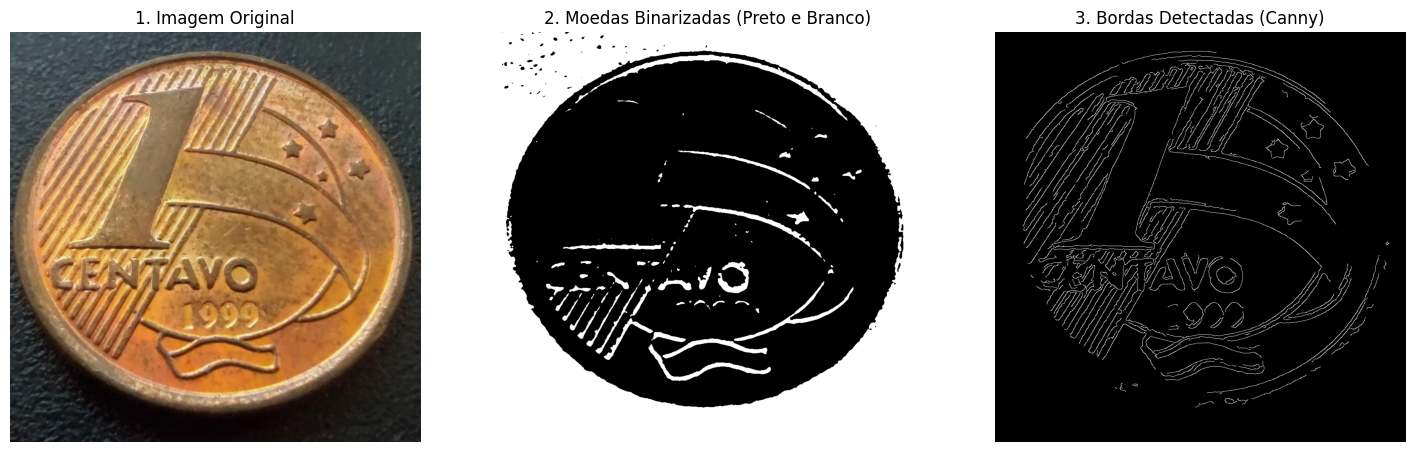

In [ ]:
print(f"Buscando a primeira imagem em: {NOME_DO_BUCKET}...")

# 1. Carregar a Primeira Imagem Válida
primeiro_blob = None
for blob in bucket.list_blobs():
    if blob.name.lower().endswith(('.jpg', '.jpeg', '.png')):
        primeiro_blob = blob
        break

if primeiro_blob is None:
    print("ERRO: Nenhuma imagem válida encontrada no bucket.")
else:
    print(f"Processando e exibindo: {primeiro_blob.name}")

    # Faz o download do conteúdo da imagem em memória (bytes)
    imagem_bytes = primeiro_blob.download_as_bytes()
    imagem_array = np.frombuffer(imagem_bytes, np.uint8)
    imagem_original = cv2.imdecode(imagem_array, cv2.IMREAD_COLOR)

    if imagem_original is None:
        print("ERRO: Imagem decodificada é nula.")
    else:

        # 1. Conversão para tons de cinza
        cinza = cv2.cvtColor(imagem_original, cv2.COLOR_BGR2GRAY)

        # 2. Suavização (Gaussian Blur)
        suavizada = cv2.GaussianBlur(cinza, (7, 7), 0)

        # 3. Limiarização (Otsu) - Cria imagem binária
        # Esta é a imagem P&B com moedas brancas e fundo preto
        _, imagem_binaria = cv2.threshold(suavizada, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # 4. Detecção de Bordas Canny
        # Os valores 50 e 150 são os thresholds mínimos e máximos para o Canny.
        # Ajuste-os para obter as bordas mais ideais para suas imagens.
        # Um threshold menor incluirá mais bordas, um maior apenas as mais fortes.
        bordas_canny = cv2.Canny(suavizada, 50, 150)

        plt.figure(figsize=(18, 6)) # Aumentei o tamanho para 3 imagens

        # 1. Imagem Original
        plt.subplot(1, 3, 1) # 1 linha, 3 colunas, posição 1
        plt.imshow(cv2.cvtColor(imagem_original, cv2.COLOR_BGR2RGB))
        plt.title('1. Imagem Original')
        plt.axis('off')

        # 2. Imagem Binarizada (Preto e Branco Puro)
        plt.subplot(1, 3, 2) # 1 linha, 3 colunas, posição 2
        # Para imagens em escala de cinza/binárias, usamos cmap='gray'
        plt.imshow(imagem_binaria, cmap='gray')
        plt.title('2. Moedas Binarizadas (Preto e Branco)')
        plt.axis('off')

        # 3. Bordas Canny
        plt.subplot(1, 3, 3) # 1 linha, 3 colunas, posição 3
        plt.imshow(bordas_canny, cmap='gray')
        plt.title('3. Bordas Detectadas (Canny)')
        plt.axis('off')

        plt.show()

Buscando a primeira imagem em: moedasbrasileiras...
Processando e exibindo: Moedas brasileiras/1-centavo-1999-rara-cdfc1bf2d7fcec1d0617174402017751-1024-1024.png


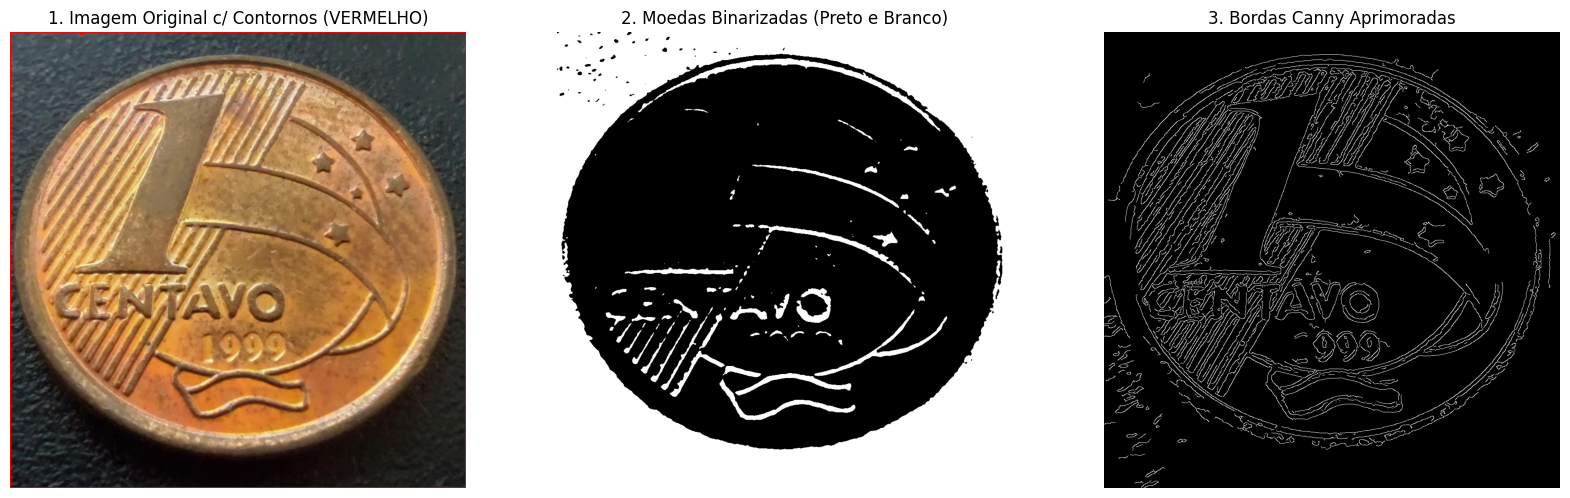

In [ ]:
print(f"Buscando a primeira imagem em: {NOME_DO_BUCKET}...")

# 1. Carregar a Primeira Imagem Válida
primeiro_blob = None
for blob in bucket.list_blobs():
    if blob.name.lower().endswith(('.jpg', '.jpeg', '.png')):
        primeiro_blob = blob
        break

if primeiro_blob is None:
    print("ERRO: Nenhuma imagem válida encontrada no bucket.")
else:
    print(f"Processando e exibindo: {primeiro_blob.name}")

    # Faz o download do conteúdo da imagem em memória (bytes)
    imagem_bytes = primeiro_blob.download_as_bytes()
    imagem_array = np.frombuffer(imagem_bytes, np.uint8)
    imagem_original = cv2.imdecode(imagem_array, cv2.IMREAD_COLOR)

    if imagem_original is None:
        print("ERRO: Imagem decodificada é nula.")
    else:
        # Criar uma cópia da imagem original para desenhar os contornos nela
        imagem_com_contornos = imagem_original.copy()

        # 1. Conversão para tons de cinza
        cinza = cv2.cvtColor(imagem_original, cv2.COLOR_BGR2GRAY)

        # 2. Suavização (Filtro Gaussiano) - Essencial para remover ruído antes de detectar bordas
        # Ajuste o tamanho do kernel (5,5) se precisar de mais ou menos suavização
        suavizada = cv2.GaussianBlur(cinza, (7, 7), 0) # Aumentei um pouco o kernel

        # 3. Limiarização (Otsu) - Cria imagem binária (preto e branco das moedas)
        _, imagem_binaria_otsu = cv2.threshold(suavizada, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # 4. Morfologia (Dilatação para fechar pequenos furos nas moedas)
        kernel_morfologico = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        dilatada_otsu = cv2.dilate(imagem_binaria_otsu, kernel_morfologico, iterations=2)

        # 5. Detecção de Contornos na imagem binarizada dilatada
        contornos, _ = cv2.findContours(dilatada_otsu, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Desenhar os contornos detectados na cópia da imagem original para visualização
        for contorno in contornos:
            if cv2.contourArea(contorno) > AREA_MINIMA_MOEDA:
                # Desenha o contorno em VERMELHO (BGR: 0, 0, 255) com espessura 2
                cv2.drawContours(imagem_com_contornos, [contorno], -1, (0, 0, 255), 2)

        # 6. Detecção de Bordas Canny Aprimorada
        # Ajustando os thresholds:
        # threshold1 (menor): captura mais bordas fracas
        # threshold2 (maior): define o que é uma borda "forte"
        # Relação típica: threshold2 = 2 * threshold1 ou 3 * threshold1
        bordas_canny = cv2.Canny(suavizada, 30, 100) # Valores ajustados (ex: 30, 90 ou 40, 120)

        plt.figure(figsize=(20, 8)) # Aumentei o tamanho da figura

        # 1. Imagem Original com Contornos
        plt.subplot(1, 3, 1) # 1 linha, 3 colunas, posição 1
        plt.imshow(cv2.cvtColor(imagem_com_contornos, cv2.COLOR_BGR2RGB))
        plt.title('1. Imagem Original c/ Contornos (VERMELHO)')
        plt.axis('off')

        # 2. Imagem Binarizada (Preto e Branco Puro do Otsu)
        plt.subplot(1, 3, 2) # 1 linha, 3 colunas, posição 2
        plt.imshow(imagem_binaria_otsu, cmap='gray')
        plt.title('2. Moedas Binarizadas (Preto e Branco)')
        plt.axis('off')

        # 3. Bordas Canny Aprimoradas
        plt.subplot(1, 3, 3) # 1 linha, 3 colunas, posição 3
        plt.imshow(bordas_canny, cmap='gray')
        plt.title('3. Bordas Canny Aprimoradas')
        plt.axis('off')

        plt.show()

Buscando a primeira imagem em: moedasbrasileiras...
Processando e exibindo: Moedas brasileiras/1-centavo-1999-rara-cdfc1bf2d7fcec1d0617174402017751-1024-1024.png


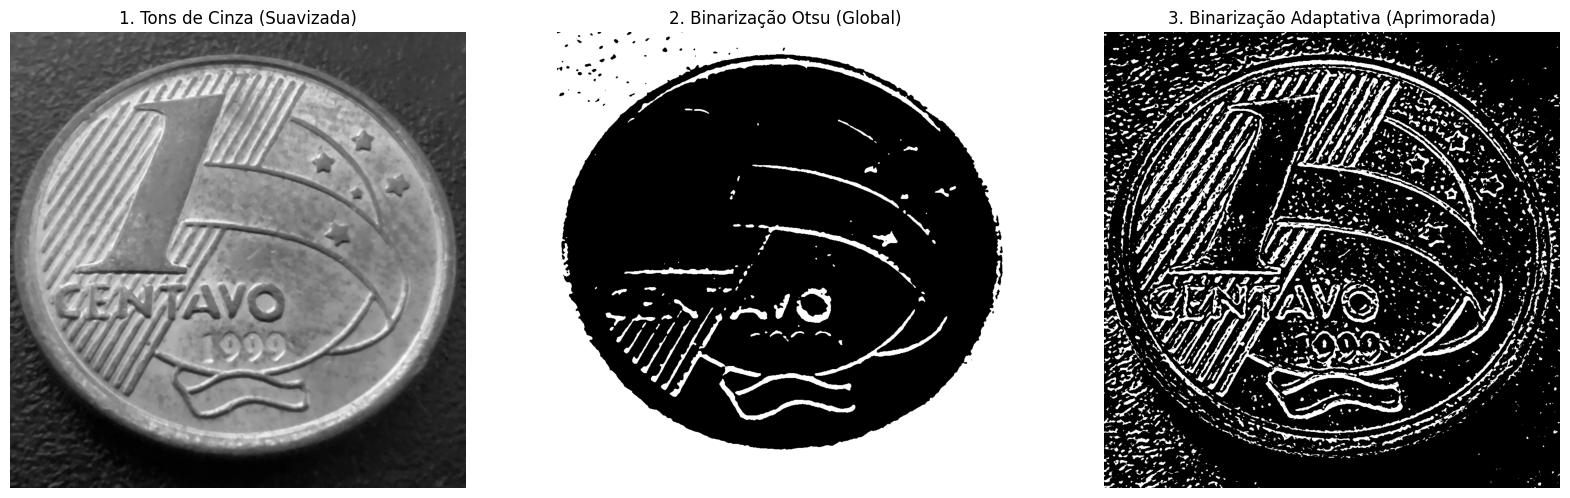

In [ ]:
print(f"Buscando a primeira imagem em: {NOME_DO_BUCKET}...")

# 1. Carregar a Primeira Imagem Válida
primeiro_blob = None
for blob in bucket.list_blobs():
    if blob.name.lower().endswith(('.jpg', '.jpeg', '.png')):
        primeiro_blob = blob
        break

if primeiro_blob is None:
    print("ERRO: Nenhuma imagem válida encontrada no bucket.")
else:
    print(f"Processando e exibindo: {primeiro_blob.name}")

    # Faz o download do conteúdo da imagem em memória (bytes)
    imagem_bytes = primeiro_blob.download_as_bytes()
    imagem_array = np.frombuffer(imagem_bytes, np.uint8)
    imagem_original = cv2.imdecode(imagem_array, cv2.IMREAD_COLOR)

    if imagem_original is None:
        print("ERRO: Imagem decodificada é nula.")
    else:
        # 1. Conversão para tons de cinza
        cinza = cv2.cvtColor(imagem_original, cv2.COLOR_BGR2GRAY)

        # 2. Suavização (Median Blur) - Excelente para remover ruído sem borrar bordas críticas
        # Kernel 5x5
        suavizada = cv2.medianBlur(cinza, 5)

        # 3. Binarização Tradicional (Otsu) - Para comparação
        _, binarizacao_otsu = cv2.threshold(suavizada, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # 4. Binarização Adaptativa (Melhoria)
        # adaptiveMethod: GAUSSIAN_C usa uma média ponderada gaussiana da vizinhança
        # thresholdType: THRESH_BINARY_INV (inverte o resultado: moeda branca, fundo preto)
        # blockSize: 21. O tamanho da vizinhança. Deve ser ímpar. Quanto maior, mais luz irregular é compensada.
        # C: 5. Uma constante que é subtraída do resultado do cálculo do limite. Ajuste-o para afinar o limite.
        binarizacao_adaptativa = cv2.adaptiveThreshold(
            suavizada,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,
            21,  # Tamanho do Bloco (Block Size)
            5    # Constante C
        )

        plt.figure(figsize=(20, 8))

        # 1. Imagem em Tons de Cinza Suavizada
        plt.subplot(1, 3, 1)
        plt.imshow(suavizada, cmap='gray')
        plt.title('1. Tons de Cinza (Suavizada)')
        plt.axis('off')

        # 2. Resultado com Limiar Otsu (O método que estava ruim)
        plt.subplot(1, 3, 2)
        plt.imshow(binarizacao_otsu, cmap='gray')
        plt.title('2. Binarização Otsu (Global)')
        plt.axis('off')

        # 3. Resultado com Limiar Adaptativo (Melhoria)
        plt.subplot(1, 3, 3)
        plt.imshow(binarizacao_adaptativa, cmap='gray')
        plt.title('3. Binarização Adaptativa (Aprimorada)')
        plt.axis('off')

        plt.show()

Buscando a primeira imagem em: moedasbrasileiras...
Processando e exibindo: Moedas brasileiras/1-centavo-1999-rara-cdfc1bf2d7fcec1d0617174402017751-1024-1024.png


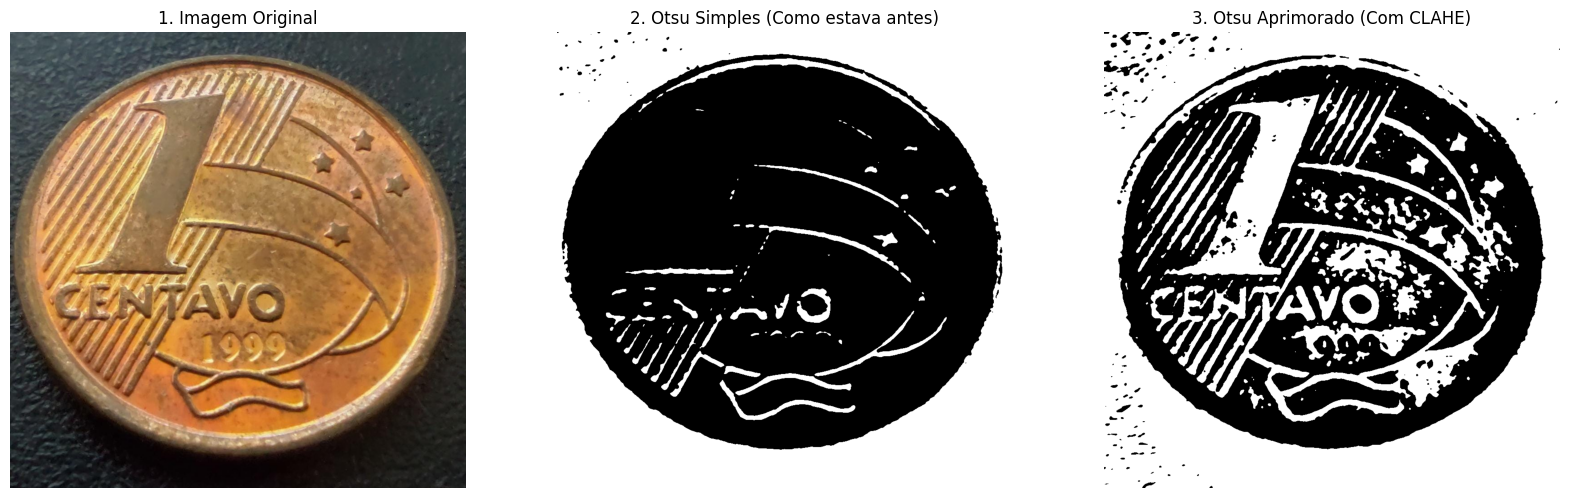

In [ ]:


print(f"Buscando a primeira imagem em: {NOME_DO_BUCKET}...")

# 1. Carregar a Primeira Imagem Válida
primeiro_blob = None
for blob in bucket.list_blobs():
    if blob.name.lower().endswith(('.jpg', '.jpeg', '.png')):
        primeiro_blob = blob
        break

if primeiro_blob is None:
    print("ERRO: Nenhuma imagem válida encontrada no bucket.")
else:
    print(f"Processando e exibindo: {primeiro_blob.name}")

    # Faz o download do conteúdo da imagem em memória (bytes)
    imagem_bytes = primeiro_blob.download_as_bytes()
    imagem_array = np.frombuffer(imagem_bytes, np.uint8)
    imagem_original = cv2.imdecode(imagem_array, cv2.IMREAD_COLOR)

    if imagem_original is None:
        print("ERRO: Imagem decodificada é nula.")
    else:
        # 1. Conversão para tons de cinza
        cinza = cv2.cvtColor(imagem_original, cv2.COLOR_BGR2GRAY)

        # 2. Aprimoramento de Contraste (CLAHE)
        # Tenta melhorar o contraste localmente. Isso ajuda o Otsu a encontrar picos mais claros.
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        contraste_aprimorado = clahe.apply(cinza)

        # 3. Suavização Aumentada (Gaussian Blur) - Kernel maior para remover mais ruído
        # Kernel 11x11 ou 13x13 é mais agressivo que 5x5 ou 7x7. Ajuste!
        suavizada = cv2.GaussianBlur(contraste_aprimorado, (11, 11), 0)

        # 4. Binarização Otsu
        # Agora o Otsu é aplicado a uma imagem com contraste melhor e menos ruído.
        _, binarizacao_otsu_melhorada = cv2.threshold(suavizada, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Para comparação, vamos rodar o Otsu simples (sem CLAHE e com kernel menor)
        suavizada_simples = cv2.GaussianBlur(cinza, (11, 11), 0)
        _, binarizacao_otsu_simples = cv2.threshold(suavizada_simples, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        plt.figure(figsize=(20, 8))

        # 1. Imagem Original
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(imagem_original, cv2.COLOR_BGR2RGB))
        plt.title('1. Imagem Original')
        plt.axis('off')

        # 2. Binarização Otsu SIMPLES (para referência)
        plt.subplot(1, 3, 2)
        plt.imshow(binarizacao_otsu_simples, cmap='gray')
        plt.title('2. Otsu Simples (Como estava antes)')
        plt.axis('off')

        # 3. Binarização Otsu MELHORADA (com CLAHE e Gaussiano maior)
        plt.subplot(1, 3, 3)
        plt.imshow(binarizacao_otsu_melhorada, cmap='gray')
        plt.title('3. Otsu Aprimorado (Com CLAHE)')
        plt.axis('off')

        plt.show()

Iniciando a busca por imagens em: gs://moedasbrasileiras/recortadas/
-> Processando: recortadas/1-centavo-1999-rara-cdfc1bf2d7fcec1d0617174402017751-1024-1024.png
   - Salvo binarizado em: processadas/binarizada_1-centavo-1999-rara-cdfc1bf2d7fcec1d0617174402017751-1024-1024_png.png
   - Salvo Canny em: processadas/canny_1-centavo-1999-rara-cdfc1bf2d7fcec1d0617174402017751-1024-1024_png.png


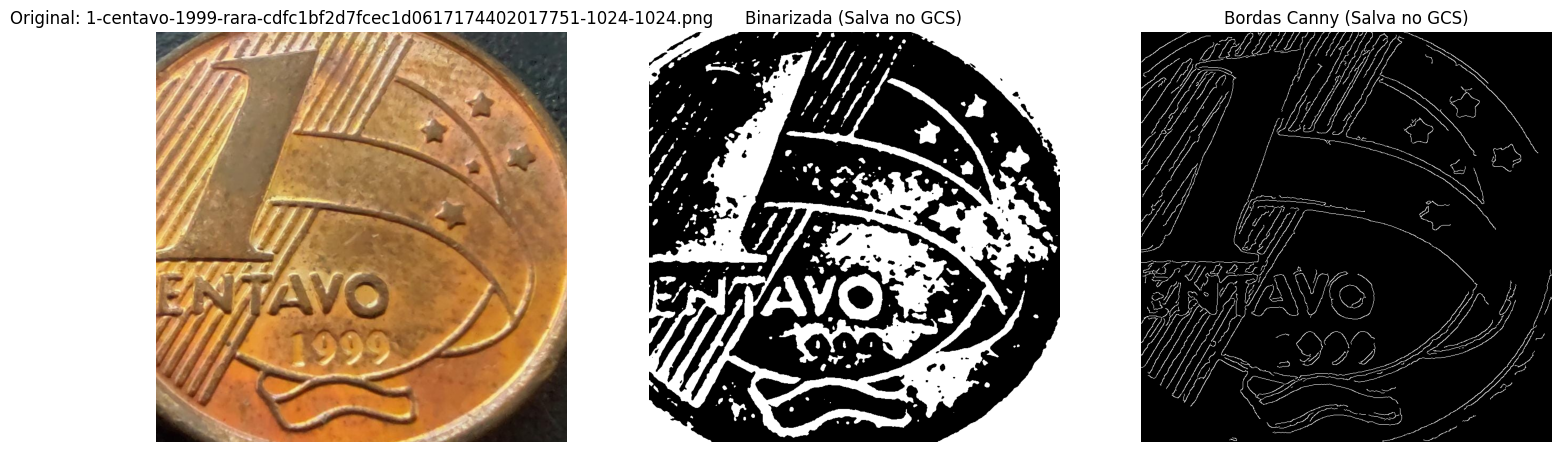

-> Processando: recortadas/1000101309-e6f3e567b82793d2ae17474475744782-1024-1024.jpg
   - Salvo binarizado em: processadas/binarizada_1000101309-e6f3e567b82793d2ae17474475744782-1024-1024_jpg.png
   - Salvo Canny em: processadas/canny_1000101309-e6f3e567b82793d2ae17474475744782-1024-1024_jpg.png
-> Processando: recortadas/1000248796-77b99255319cf4cb9617070062556040-1024-1024.jpg
   - Salvo binarizado em: processadas/binarizada_1000248796-77b99255319cf4cb9617070062556040-1024-1024_jpg.png
   - Salvo Canny em: processadas/canny_1000248796-77b99255319cf4cb9617070062556040-1024-1024_jpg.png
-> Processando: recortadas/10_centavos_2a_familia_fc_343_1_8776bb0c5060578bec640d7627c55ba5.jpg
   - Salvo binarizado em: processadas/binarizada_10_centavos_2a_familia_fc_343_1_8776bb0c5060578bec640d7627c55ba5_jpg.png
   - Salvo Canny em: processadas/canny_10_centavos_2a_familia_fc_343_1_8776bb0c5060578bec640d7627c55ba5_jpg.png
-> Processando: recortadas/1264a22d3360eb56304a3063728b913f.jpg
   - Salvo b

In [ ]:
def processar_e_salvar_imagem(blob_origem):
    """
    Processa uma imagem do GCS (binariza e aplica Canny) e salva os
    resultados no GCS na pasta de destino.
    """
    print(f"-> Processando: {blob_origem.name}")

    # 1. Download do conteúdo da imagem em memória (bytes)
    try:
        imagem_bytes = blob_origem.download_as_bytes()
        imagem_array = np.frombuffer(imagem_bytes, np.uint8)
        imagem_original = cv2.imdecode(imagem_array, cv2.IMREAD_COLOR)

        if imagem_original is None:
            print(f"ERRO: Imagem decodificada é nula para {blob_origem.name}. Pulando.")
            return

        # Obter o nome do arquivo (sem o prefixo da pasta)
        nome_arquivo = os.path.basename(blob_origem.name)

        # Conversão para tons de cinza e Suavização
        cinza = cv2.cvtColor(imagem_original, cv2.COLOR_BGR2GRAY)
        suavizada = cv2.GaussianBlur(cinza, (7, 7), 0)

        # 1. Limiarização (Otsu) - Imagem Binarizada
        _, imagem_binaria = cv2.threshold(suavizada, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # 2. Detecção de Bordas Canny
        bordas_canny = cv2.Canny(suavizada, 50, 150)

        # Parâmetros de compressão para JPEG ou PNG
        # Recomenda-se PNG para imagens com menos cores/linhas (como Canny/Binária)
        encode_param = [int(cv2.IMWRITE_PNG_COMPRESSION), 9]

        # --- Salvar Imagem Binarizada ---
        nome_binaria = f"{PASTA_DESTINO}binarizada_{nome_arquivo.replace('.', '_')}.png"
        _, buffer_binaria = cv2.imencode('.png', imagem_binaria, encode_param)
        blob_binaria = bucket.blob(nome_binaria)
        blob_binaria.upload_from_string(buffer_binaria.tobytes(), content_type='image/png')
        print(f"   - Salvo binarizado em: {nome_binaria}")

        # --- Salvar Bordas Canny ---
        nome_canny = f"{PASTA_DESTINO}canny_{nome_arquivo.replace('.', '_')}.png"
        _, buffer_canny = cv2.imencode('.png', bordas_canny, encode_param)
        blob_canny = bucket.blob(nome_canny)
        blob_canny.upload_from_string(buffer_canny.tobytes(), content_type='image/png')
        print(f"   - Salvo Canny em: {nome_canny}")

    except Exception as e:
        print(f"ERRO inesperado ao processar {blob_origem.name}: {e}")

    # Exibir a primeira imagem processada (Opcional, para Jupyter Notebooks)
    # Você pode remover este bloco se estiver rodando como script
    if 'primeira_vez' not in processar_e_salvar_imagem.__dict__:
        plt.figure(figsize=(18, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(imagem_original, cv2.COLOR_BGR2RGB))
        plt.title(f'Original: {nome_arquivo}')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(imagem_binaria, cmap='gray')
        plt.title('Binarizada (Salva no GCS)')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(bordas_canny, cmap='gray')
        plt.title('Bordas Canny (Salva no GCS)')
        plt.axis('off')

        plt.show()
        # Marca que a primeira imagem já foi exibida
        processar_e_salvar_imagem.primeira_vez = False


# --- Execução Principal ---
print(f"Iniciando a busca por imagens em: gs://{NOME_DO_BUCKET}/{PASTA_ORIGEM}")

contador = 0
for blob in bucket.list_blobs(prefix=PASTA_ORIGEM):
    # Ignora o próprio "diretório" se estiver listado e verifica se é imagem
    if blob.name == PASTA_ORIGEM or not blob.name.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    processar_e_salvar_imagem(blob)
    contador += 1

print("-" * 40)
print(f"Processamento concluído. {contador} imagens processadas e salvas em gs://{NOME_DO_BUCKET}/{PASTA_DESTINO}")

# Código principal - processamento

In [28]:
def image_segmentation(image):
    """
    Detecta moedas circulares usando HoughCircles em uma imagem BGR,
    aplica pré-processamento CLAHE para melhorar o contraste e retorna
    uma lista das moedas cortadas (para o pipeline de treinamento).
    """
    imagens_cortadas = []

    # 1. Pré-processamento
    # Converte para escala de cinza
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 1.1. Aprimoramento de Contraste (CLAHE)
    # Melhora o contraste localmente, útil para moedas em diferentes condições de luz
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contraste_aprimorado = clahe.apply(gray)

    # 1.2. Suavização (Blur)
    # Reduz o ruído para que o HoughCircles funcione melhor
    blur = cv2.GaussianBlur(contraste_aprimorado, (9, 9), cv2.BORDER_DEFAULT)

    # 2. Detecção de Círculos (HoughCircles)
    all_circs = cv2.HoughCircles(
        blur,
        cv2.HOUGH_GRADIENT,
        dp=0.9,
        minDist=MIN_DIST,
        param1=50,
        param2=PARAM2,
        minRadius=MIN_RADIUS,
        maxRadius=MAX_RADIUS
    )

    # 3. Processamento e Corte
    if all_circs is not None:
        # Converte as coordenadas para inteiros
        all_circs = np.uint16(np.around(all_circs))

        for corte in all_circs[0]:
            x, y, r = corte[0], corte[1], corte[2]

            # 4. Lógica de Corte (Cropping)
            # Adiciona uma pequena margem (ex: 10%) ao raio para o corte,
            # para capturar toda a borda da moeda.
            r_margem = int(r * 1.1)

            # Define os limites do quadrado de corte, garantindo que não saia da imagem:
            x_min = max(0, x - r_margem)
            x_max = min(image.shape[1], x + r_margem)
            y_min = max(0, y - r_margem)
            y_max = min(image.shape[0], y + r_margem)

            # Corta a imagem (formato [y_min:y_max, x_min:x_max])
            crop = image[y_min : y_max, x_min : x_max]

            # Garante que o corte não está vazio
            if crop.size > 0:
                 imagens_cortadas.append(crop)

    return imagens_cortadas

In [ ]:
import cv2
import numpy as np
import io
import os
# Certifique-se de que a biblioteca google.cloud.storage foi importada em uma célula anterior
# e que a variável 'bucket' está definida (por exemplo, bucket = storage_client.bucket('moedasbrasileiras'))

# --- CONFIGURAÇÕES CRÍTICAS ---

# 🚨 PREFIXO ONDE ESTÃO AS PASTAS DE ORIGEM (SEM O NOME DO BUCKET NA FRENTE)
PASTA_ORIGEM_RAIZ = 'classes/'

# Lista exata dos nomes das pastas de origem (que serão os rótulos)
ROTULOS_FINAIS_GCS = [
    "cincocentavos",
    "cinquentacentavos",
    "dezcentavos",
    "umcentavo",
    "umreal",
    "vinteecincocentavos",
]

# Pasta de destino no Bucket
PASTA_DESTINO_RAIZ = 'cortadas/'

# --- 1. FUNÇÃO AUXILIAR PARA O PROCESSO ---

# Assumindo que 'image_segmentation' está definida e acessível.
def processar_e_salvar_blob(blob_original, bucket, rotulo_final, PASTA_DESTINO_RAIZ):
    """
    Função interna para carregar, segmentar e salvar uma única imagem cortada no GCS.
    """
    global total_moedas_cortadas_salvas

    blob_name = blob_original.name

    try:
        # Carregar Imagem
        imagem_bytes = blob_original.download_as_bytes()
        imagem_array = np.frombuffer(imagem_bytes, np.uint8)
        imagem_original = cv2.imdecode(imagem_array, cv2.IMREAD_COLOR)

        if imagem_original is None:
            return

        # CHAMA A FUNÇÃO DE SEGMENTAÇÃO
        moedas_cortadas = image_segmentation(imagem_original)

        # SALVAR OS CORTES DE VOLTA NO GCS
        for i, moeda_cortada in enumerate(moedas_cortadas):
            # Impedir a tentativa de salvar arrays vazios (caso a segmentação falhe para uma imagem específica)
            if moeda_cortada.size == 0: continue

            # Nome e Caminho de Destino no GCS
            nome_arquivo_destino = f"{os.path.splitext(os.path.basename(blob_name))[0]}_{i}.jpg"
            # Caminho de destino: 'cortadas/cincocentavos/arquivo_0.jpg'
            caminho_destino = f"{PASTA_DESTINO_RAIZ}{rotulo_final}/{nome_arquivo_destino}"

            # Codifica a imagem para bytes
            _, buffer = cv2.imencode('.jpg', moeda_cortada, [int(cv2.IMWRITE_JPEG_QUALITY), 90])
            imagem_bytes_saida = buffer.tobytes()

            # Upload
            blob_destino = bucket.blob(caminho_destino)
            blob_destino.upload_from_string(imagem_bytes_saida, content_type='image/jpeg')

            # Atualiza o contador global
            global total_moedas_cortadas_salvas
            total_moedas_cortadas_salvas += 1

    except Exception as e:
        # 🚨 Este print é importante para capturar erros específicos por arquivo
        print(f"Ocorreu um erro ao processar {blob_name} ou salvar em {caminho_destino}: {e}")
        return

# --- 2. LOOP PRINCIPAL POR PASTA ---

global total_moedas_cortadas_salvas
total_moedas_cortadas_salvas = 0
total_arquivos_processados = 0

print("Iniciando processamento em lote e upload para 'cortadas/'...")

for rotulo_final in ROTULOS_FINAIS_GCS:

    # Prefixos de busca: 'moedasbrasileiras/classes/cincocentavos/'
    prefixo_origem_completo = f"{PASTA_ORIGEM_RAIZ}{rotulo_final}/"

    print(f"\n-> Processando ORIGEM: {prefixo_origem_completo} -> DESTINO: {PASTA_DESTINO_RAIZ}{rotulo_final}/")

    # Lista todos os blobs dentro do prefixo
    # O TensorFlow usa o nome do bucket implicitamente
    blobs_iterator = bucket.list_blobs(prefix=prefixo_origem_completo)

    for blob_original in blobs_iterator:
        # Pular o próprio prefixo da pasta
        if blob_original.name == prefixo_origem_completo: continue
        # Processar apenas arquivos de imagem
        if not blob_original.name.lower().endswith(('.jpg', '.jpeg', '.png')): continue

        # Chamada da função de segmentação e salvamento
        processar_e_salvar_blob(blob_original, bucket, rotulo_final, PASTA_DESTINO_RAIZ)
        total_arquivos_processados += 1

        if total_arquivos_processados % 100 == 0:
            print(f"  ... {total_arquivos_processados} arquivos originais processados. ({total_moedas_cortadas_salvas} moedas salvas).")


print(f"\n\n✅ Processamento TOTAL concluído.")
print(f"Total de arquivos originais processados: {total_arquivos_processados}")
print(f"Total de moedas cortadas e salvas no GCS em '{PASTA_DESTINO_RAIZ}': {total_moedas_cortadas_salvas}")

Iniciando processamento em lote e upload para 'cortadas/'...

-> Processando ORIGEM: classes/cincocentavos/ -> DESTINO: cortadas/cincocentavos/
